  0%|          | 0/30 [00:00<?, ?it/s]MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
  0%|          | 0/30 [03:30<?, ?it/s]


KeyboardInterrupt: 

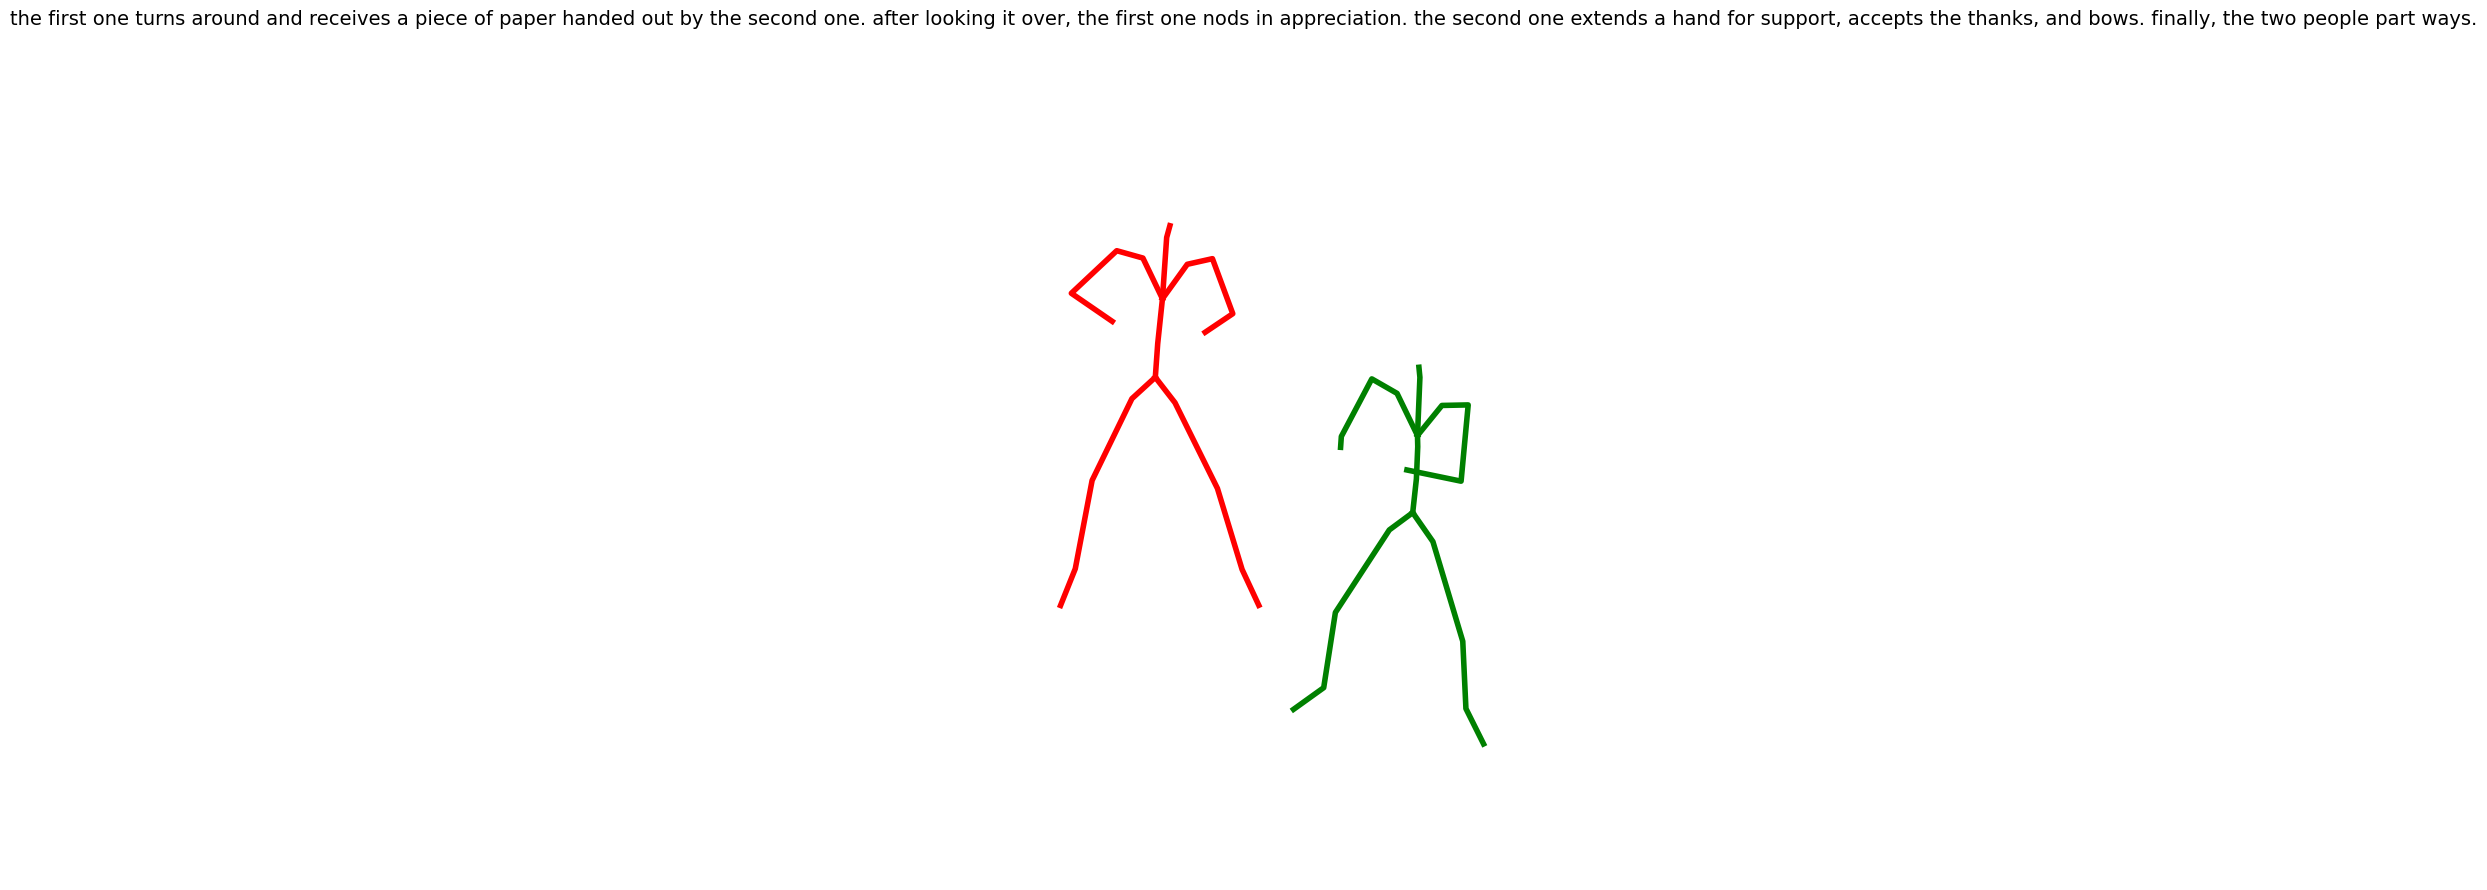

In [ ]:
import os
import numpy as np
import pandas as pd
from os.path import join as pjoin
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ------------------------------
# Kinematic chain (2 personnes)
# ------------------------------
kinematic_chain = [
    [0, 2, 5, 8, 11],
    [0, 1, 4, 7, 10],
    [0, 3, 6, 9, 12, 15],
    [9, 14, 17, 19, 21],
    [9, 13, 16, 18, 20]
]

# ------------------------------
# Fonction pour générer GIF
# ------------------------------
def plot_3d_motion(save_path, kinematic_tree, mp_joints, title, figsize=(10,10), fps=30, radius=4):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    def init():
        ax.set_xlim3d([-radius / 4, radius / 4])
        ax.set_ylim3d([0, radius / 2])
        ax.set_zlim3d([0, radius / 2])
        fig.suptitle(title, fontsize=14)
        ax.grid(False)
        
    init()
    
    mp_data = []
    frame_number = min([data.shape[0] for data in mp_joints])
    colors = ['red', 'green', 'black', 'red', 'blue',
              'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue',
              'darkred', 'darkred', 'darkred', 'darkred', 'darkred']
    mp_offset = list(range(-len(mp_joints)//2, len(mp_joints)//2, 1))
    mp_colors = [[colors[i]]*15 for i in range(len(mp_offset))]
    
    for i,joints in enumerate(mp_joints):
        data = joints.copy().reshape(len(joints), -1, 3)
        MINS = data.min(axis=0).min(axis=0)
        data[:, :, 1] -= MINS[1]  # align to ground
        mp_data.append({"joints": data})
    
    def update(index):
        ax.cla()
        ax.set_axis_off()
        ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])
        ax.view_init(elev=120, azim=-90)
        for pid, data in enumerate(mp_data):
            for i, (chain, color) in enumerate(zip(kinematic_tree, mp_colors[pid])):
                lw = 4.0 if i < 5 else 2.0
                ax.plot3D(data["joints"][index, chain, 0],
                          data["joints"][index, chain, 1],
                          data["joints"][index, chain, 2],
                          color=color, linewidth=lw)
        fig.suptitle(title, fontsize=14)
    
    ani = FuncAnimation(fig, update, frames=frame_number, interval=1000/fps, repeat=False)
    ani.save(save_path, fps=fps)
    plt.close()

# ------------------------------
# Fonction principale : CSV → GIFs
# ------------------------------
def csvTogifs(csv_path):
    df = pd.read_csv(csv_path)
    
    data_root = "./data/test"
    output_root = "./gifs_export"
    os.makedirs(output_root, exist_ok=True)
    
    candidate_cols = [col for col in df.columns if col.startswith("candidate")]
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        query_id = str(row["query_id"])
        batch_in = pjoin(data_root, query_id)
        batch_out = pjoin(output_root, f"batch_{query_id}")
        os.makedirs(batch_out, exist_ok=True)
        
        # Lire la query
        text_file = pjoin(batch_in, "text.txt")
        query_text = ""
        if os.path.exists(text_file):
            with open(text_file) as f:
                query_text = f.read().strip()
        else:
            query_text = "Query non trouvée"
        
        # Générer GIFs
        for i, col in enumerate(candidate_cols, start=1):
            motion_name = row[col]
            motion_file = "motion_"+motion_name + ".npy"
            motion_path = pjoin(batch_in, motion_file)
            motion = np.load(motion_path)
            pos1 = motion[:, :22*3]
            pos2 = motion[:, 22*3+21*6 : 22*3+21*6+22*3]
            gif_name = f"candidate_{i}.gif"
            gif_path = pjoin(batch_out, gif_name)
            plot_3d_motion(gif_path, kinematic_chain, [pos1, pos2], query_text)
    
    print("\n All GIFs exported successfully!")

# ------------------------------
# Exemple d'appel
# ------------------------------
csvTogifs("./data/submission1.csv")
